In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import math
from fileinput import FileInput 

In [2]:
with FileInput("C:/Users/flavi/Travail/Switch-23/models/logs_file/latenessV2.csv", inplace=True, 
                   backup='.bak') as f: 
  
        # Iterating over every and changing 
        # the search_text with replace_text 
        # using the replace function 
        for line in f:
            line = line.replace("file_list.header","")
            line = line.replace("],[","\n")
            line = line.replace("]","")
            line = line.replace("[","")
            print(line,end='')

In [3]:
road = gpd.read_file("C:/Users/flavi/Travail/Switch-23/includes/tests/roadImportance4/roads.shp")
gama_file = pd.read_csv("C:/Users/flavi/Travail/Switch-23/models/logs_file/latenessV2.csv")

In [4]:
gama_file

,ID,TopoId,distance,entry date,duration,mean speed,lateness,activity
0,'Car17053','TRONROUT0000000073475276',9,'2023-10-12 06:57:00',1.0,33,0,0
1,'Car21385','TRONROUT0000000073502967',6,'2023-10-12 06:57:00',1.0,22,0,0
2,'Car7305','TRONROUT0000002223815566',12,'2023-10-12 06:57:00',1.0,42,0,0
3,'Car12606','TRONROUT0000000073547959',2,'2023-10-12 06:57:00',1.0,8,0,0
4,'Car4448','TRONROUT0000000073511262',19,'2023-10-12 06:57:00',2.0,34,0,0
...,...,...,...,...,...,...,...,...
28335666,'Car62791','TRONROUT0000000073461798',625,'2023-10-12 23:06:47',36.0,63,0,0
28335667,'Car62791','TRONROUT0000000073458448',125,'2023-10-12 23:07:23',8.0,56,0,0
28335668,'Car62791','TRONROUT0000000073458439',251,'2023-10-12 23:07:31',15.0,60,0,0
28335669,'Car62791','TRONROUT0000000073458451',162,'2023-10-12 23:07:46',10.0,58,0,0


In [7]:
gama_file['late max'] = gama_file['lateness']
gama_file['late mean'] = gama_file['lateness']
traited_file = gama_file.groupby(['TopoId'],group_keys=True).agg({
                                        "distance": lambda x: list(np.unique(x))[0],\
                                        "duration": lambda x: np.mean(x),\
                                        "mean speed":lambda x: np.mean(x),\
                                        "late max" : lambda x: np.max(x),\
                                        "late mean": lambda x: np.mean(x),\
                                        "ID" : lambda x:len(list(x))
                                    })
traited_file = traited_file.reset_index()
traited_file['TopoId'] = traited_file['TopoId'].map(lambda x : (x.replace("'","")))
traited_file = traited_file.rename(columns ={"ID":"frequentation"})
traited_file
#gama_file.to_csv("C:/Users/flavi/Travail/Switch-23/models/logs_file/meanMap.csv")

,TopoId,distance,duration,mean speed,late max,late mean,frequentation
0,TRONROUT0000000073456159,7,1.000000,27.000000,0,0.000000,161
1,TRONROUT0000000073456162,15,5.472626,23.117318,45,3.472626,895
2,TRONROUT0000000073456164,30,3.000000,36.000000,0,0.000000,161
3,TRONROUT0000000073456167,13,2.044064,23.771114,4,0.044064,1634
4,TRONROUT0000000073456168,129,39.112108,28.618834,185,28.112108,2676
...,...,...,...,...,...,...,...
8137,TRONROUT0000002330723029,149,8.027316,66.834256,6,0.027316,2709
8138,TRONROUT0000002330723030,176,10.000000,63.000000,0,0.000000,1637
8139,TRONROUT0000002330723032,13,2.005688,22.973570,4,0.005688,2989
8140,TRONROUT0000002330723033,25,4.200358,22.424687,8,0.200358,2795


In [8]:
#pd.concat([gama_file,road], keys=['topoID','ID'])
roadMean = traited_file.merge(road, left_on='TopoId', right_on='ID')

In [9]:
roadMean = gpd.GeoDataFrame(roadMean)
roadMean

,TopoId,distance,duration,mean speed,late max,late mean,frequentation,ID,NATURE,IMPORTANCE,NB_VOIES,SENS,VIT_MOY_VL,LARGEUR,VEHICULES,geometry
0,TRONROUT0000000073456159,7,1.000000,27.000000,0,0.000000,161,TRONROUT0000000073456159,Route à 1 chaussée,3,3.0,Sens inverse,45,9,0,"LINESTRING Z (572182.500 6293613.500 151.500, ..."
1,TRONROUT0000000073456159,7,1.000000,27.000000,0,0.000000,161,TRONROUT0000000073456159,Route à 1 chaussée,3,3.0,Sens direct,45,9,0,"LINESTRING Z (572182.500 6293613.500 151.500, ..."
2,TRONROUT0000000073456162,15,5.472626,23.117318,45,3.472626,895,TRONROUT0000000073456162,Route à 1 chaussée,3,3.0,Sens inverse,45,9,0,"LINESTRING Z (572068.000 6293497.800 139.500, ..."
3,TRONROUT0000000073456162,15,5.472626,23.117318,45,3.472626,895,TRONROUT0000000073456162,Route à 1 chaussée,3,3.0,Sens direct,45,9,0,"LINESTRING Z (572068.000 6293497.800 139.500, ..."
4,TRONROUT0000000073456164,30,3.000000,36.000000,0,0.000000,161,TRONROUT0000000073456164,Route à 1 chaussée,3,3.0,Sens inverse,45,9,0,"LINESTRING Z (572177.300 6293608.100 151.000, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,TRONROUT0000002330723030,176,10.000000,63.000000,0,0.000000,1637,TRONROUT0000002330723030,Route à 2 chaussées,3,2.0,Sens direct,70,5.5,0,"LINESTRING Z (571116.200 6271503.200 149.400, ..."
10642,TRONROUT0000002330723032,13,2.005688,22.973570,4,0.005688,2989,TRONROUT0000002330723032,Rond-point,3,2.0,Sens direct,25,5,0 2,"LINESTRING Z (571075.200 6271505.900 149.100, ..."
10643,TRONROUT0000002330723033,25,4.200358,22.424687,8,0.200358,2795,TRONROUT0000002330723033,Rond-point,3,2.0,Sens direct,25,5,0 2,"LINESTRING Z (571068.500 6271495.000 149.300, ..."
10644,TRONROUT0000002330723235,38,4.000000,35.000000,0,0.000000,2806,TRONROUT0000002330723235,Route à 1 chaussée,3,4.0,Sens inverse,45,12,0,"LINESTRING Z (573809.500 6276996.600 142.600, ..."


In [10]:
roadMean.to_file("C:/Users/flavi/Travail/Switch-23/DataScript/OUT/meanMapP5R3.shp")

C:\Users\flavi\AppData\Local\Temp\ipykernel_26288\2603155821.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  roadMean.to_file("C:/Users/flavi/Travail/Switch-23/DataScript/OUT/meanMapP5R3.shp")


In [53]:
roadMean['lateness'] = roadMean['lateness'].map(lambda x : 0 if x==0 else math.log(x,))
roadMean['lateness'] = roadMean['lateness'].map(lambda x : 6000 if x>6000 else x)

In [11]:
roadMean = gpd.read_file("C:/Users/flavi/Travail/Switch-23/DataScript/OUT/meanMapP5R3.shp")
#roadMean = gpd.read_file("C:/Users/flavi/Travail/Switch-23/DataScript/OUT/meanMap-10OnRoad1.shp")


In [17]:
roadMean

,TopoId,distance,duration,mean speed,lateness,frequentat,ID,NATURE,IMPORTANCE,NB_VOIES,SENS,VIT_MOY_VL,LARGEUR,VEHICULES,geometry
0,TRONROUT0000000073456159,7,1.000000,27.000000,0,308,TRONROUT0000000073456159,Route à 1 chaussée,3,3.0,Sens inverse,45,9,0,"LINESTRING Z (572182.500 6293613.500 151.500, ..."
1,TRONROUT0000000073456159,7,1.000000,27.000000,0,308,TRONROUT0000000073456159,Route à 1 chaussée,3,3.0,Sens direct,45,9,0,"LINESTRING Z (572182.500 6293613.500 151.500, ..."
2,TRONROUT0000000073456162,15,11.242319,22.199420,102,1725,TRONROUT0000000073456162,Route à 1 chaussée,3,3.0,Sens inverse,45,9,0,"LINESTRING Z (572068.000 6293497.800 139.500, ..."
3,TRONROUT0000000073456162,15,11.242319,22.199420,102,1725,TRONROUT0000000073456162,Route à 1 chaussée,3,3.0,Sens direct,45,9,0,"LINESTRING Z (572068.000 6293497.800 139.500, ..."
4,TRONROUT0000000073456164,30,3.000000,36.000000,0,310,TRONROUT0000000073456164,Route à 1 chaussée,3,3.0,Sens inverse,45,9,0,"LINESTRING Z (572177.300 6293608.100 151.000, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10663,TRONROUT0000002330723030,176,10.000000,63.000000,0,2872,TRONROUT0000002330723030,Route à 2 chaussées,3,2.0,Sens direct,70,5.5,0,"LINESTRING Z (571116.200 6271503.200 149.400, ..."
10664,TRONROUT0000002330723032,13,2.006479,22.970302,4,5556,TRONROUT0000002330723032,Rond-point,3,2.0,Sens direct,25,5,0 2,"LINESTRING Z (571075.200 6271505.900 149.100, ..."
10665,TRONROUT0000002330723033,25,4.136372,22.621658,8,5199,TRONROUT0000002330723033,Rond-point,3,2.0,Sens direct,25,5,0 2,"LINESTRING Z (571068.500 6271495.000 149.300, ..."
10666,TRONROUT0000002330723235,38,4.000000,35.000000,0,5596,TRONROUT0000002330723235,Route à 1 chaussée,3,4.0,Sens inverse,45,12,0,"LINESTRING Z (573809.500 6276996.600 142.600, ..."


Text(0.5, 1.0, 'roads duration (109440 individu, road importance 3)')

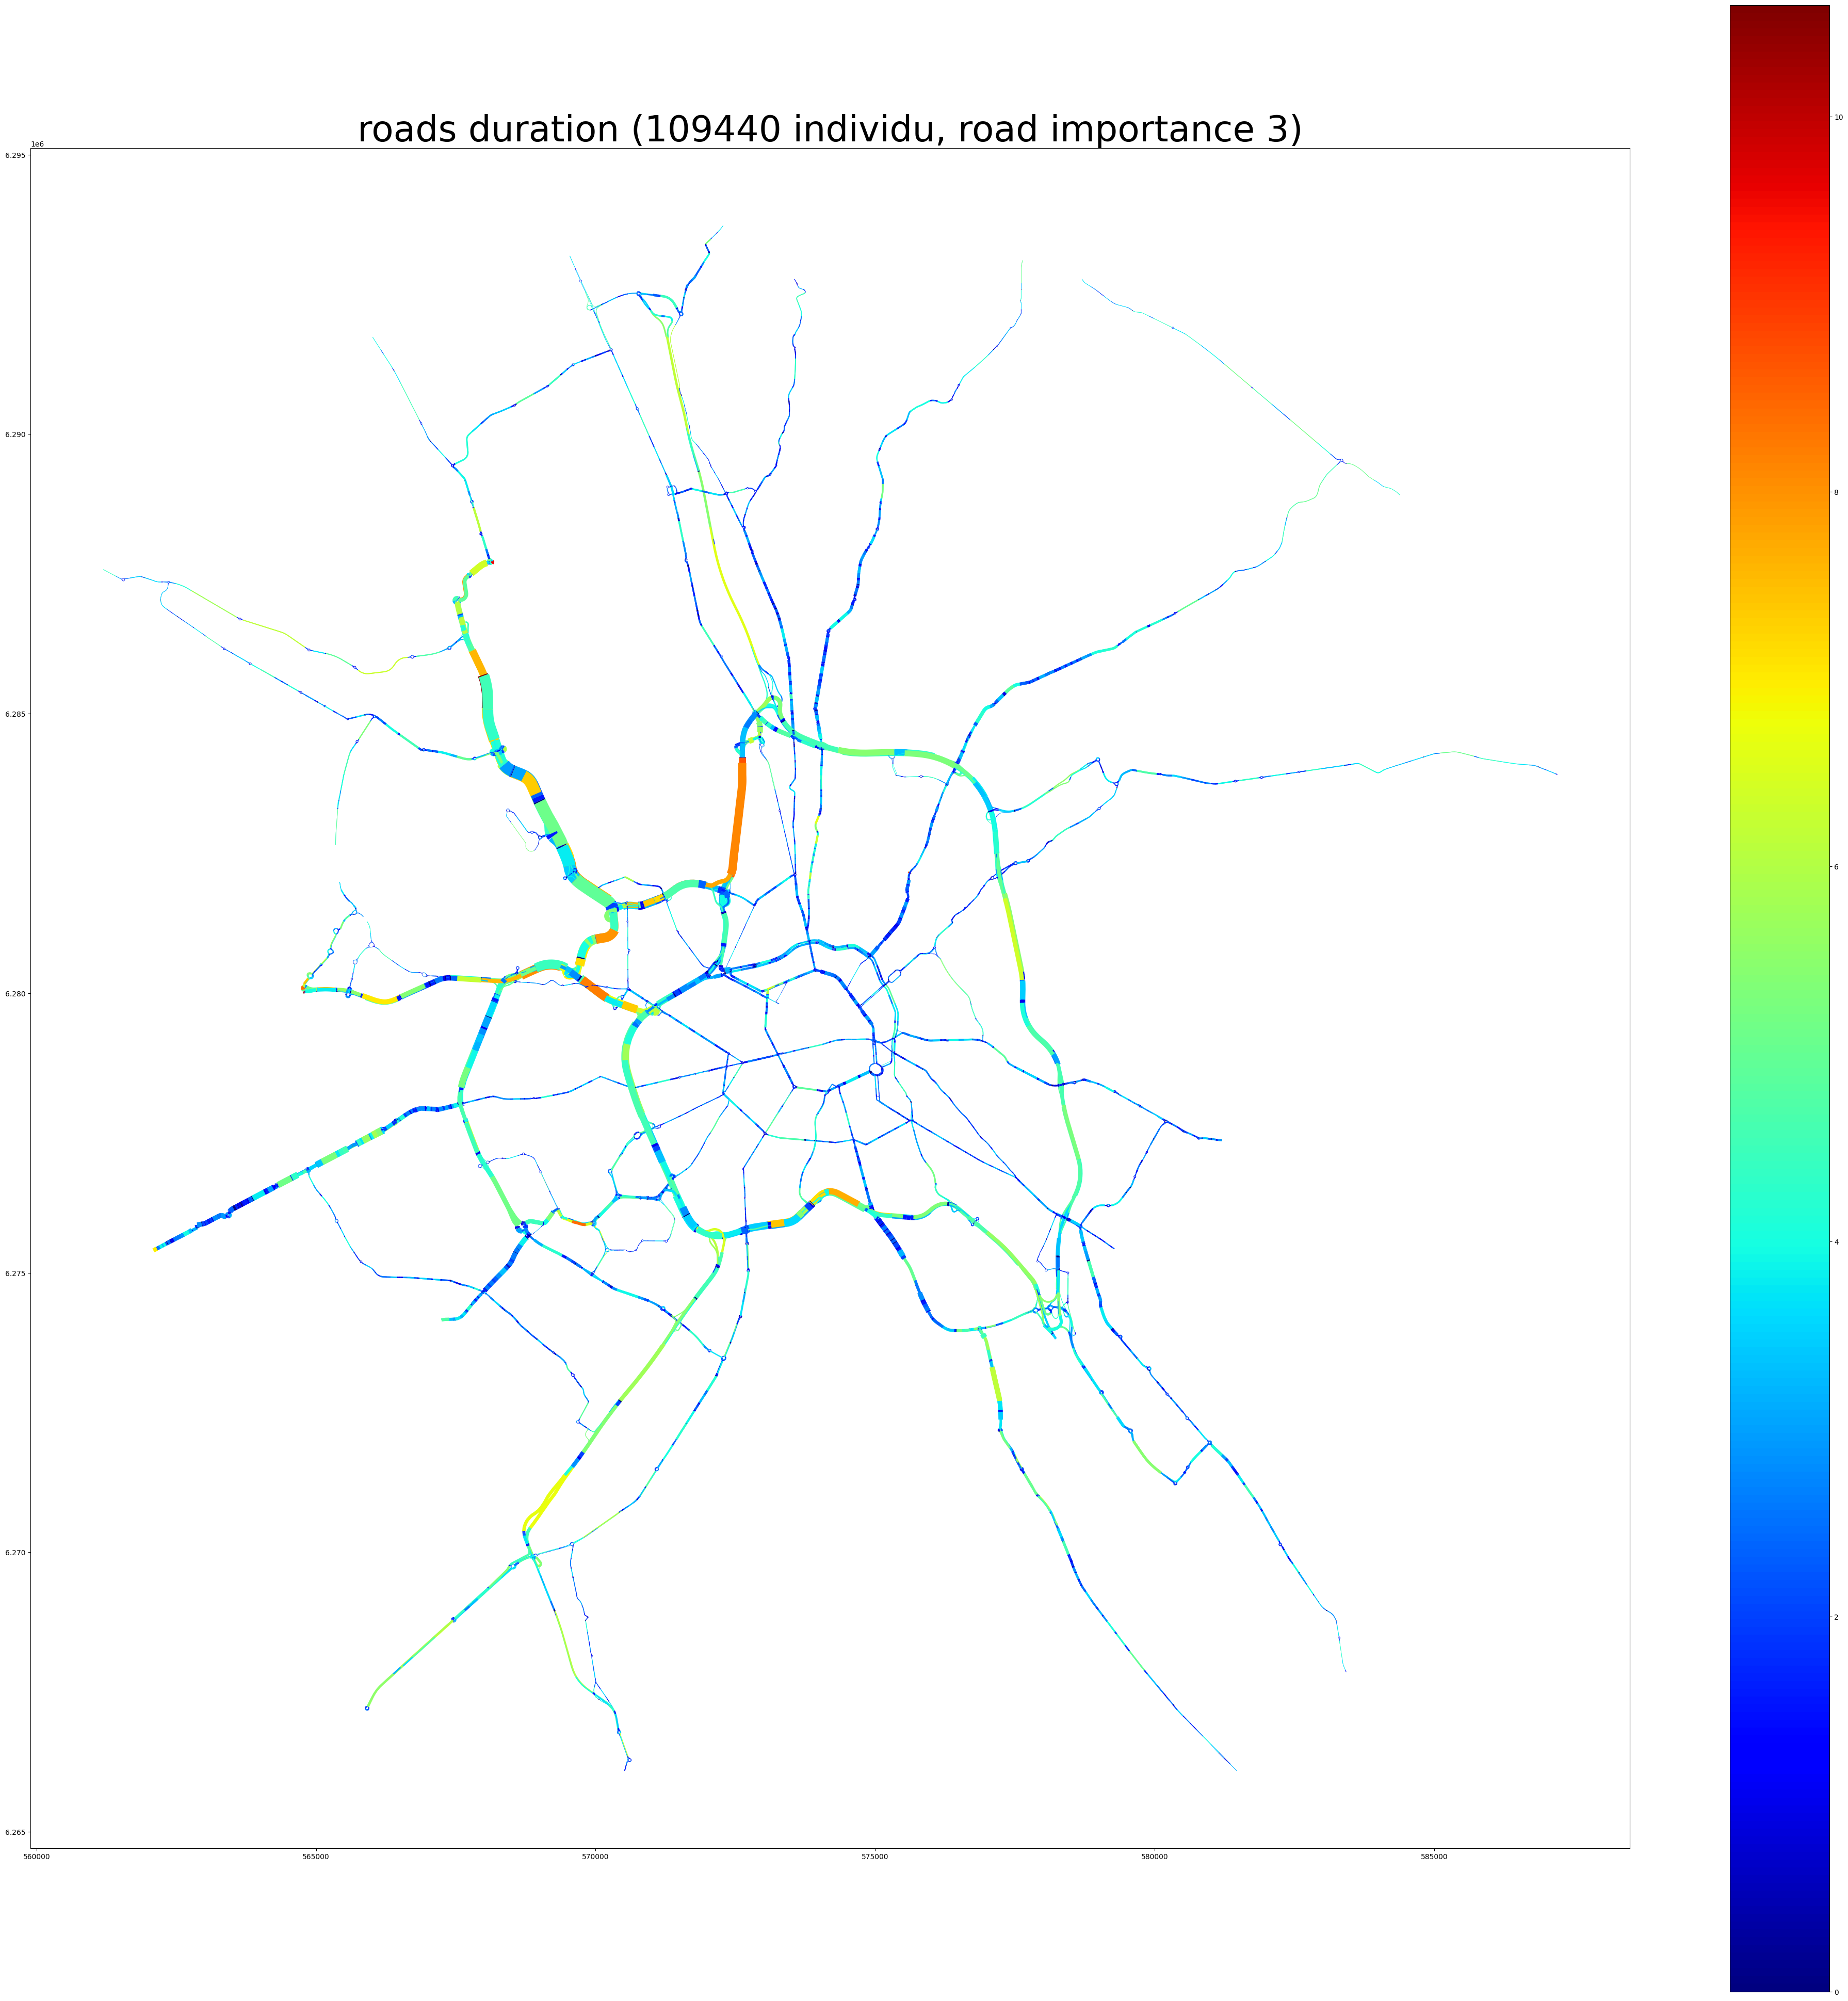

In [12]:
heatmap = roadMean.plot(figsize = (50,50), column=roadMean['duration'].map(lambda x : 0 if x==0 else math.log(x,2)), legend=True, cmap='jet', linewidth=0.5+roadMean['frequentat']/2000)
heatmap.set_title("roads duration (109440 individu, road importance 3)",size='50')

<Axes: >

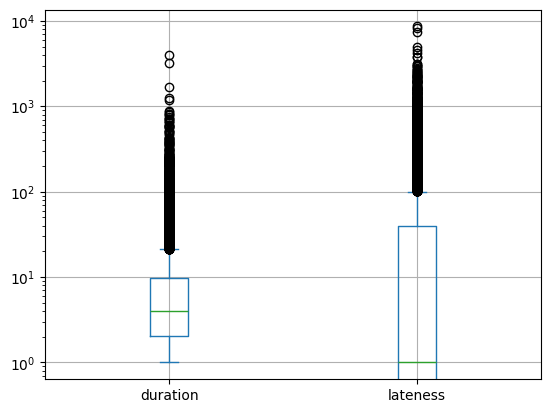

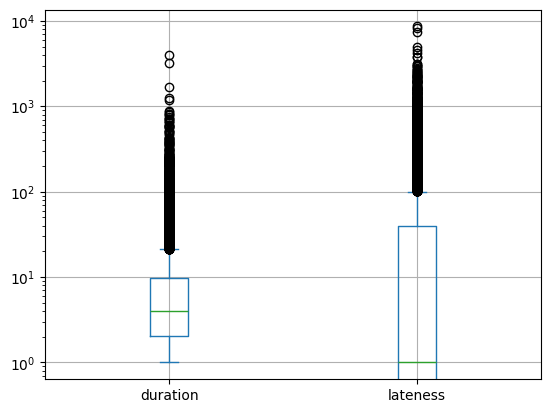

In [47]:
roadMean = gpd.read_file("C:/Users/flavi/Travail/Switch-23/DataScript/OUT/meanMap.shp")
roadMeanMinus10 = gpd.read_file("C:/Users/flavi/Travail/Switch-23/DataScript/OUT/meanMap-10OnRoad1.shp")
roadMean.plot.box(column=['duration','lateness'],logy=True,grid=True)
roadMeanMinus10.plot.box(column=['duration','lateness'],logy=True,grid=True)

In [31]:
np.max(gama_file['lateness'])

4644

In [37]:
etrange_route1 = gama_file.loc[gama_file['TopoId']=="'TRONROUT0000000073477492'"]
etrange_route2 = gama_file.loc[gama_file['TopoId']=="'TRONROUT0000000073477495'"]
etrange_route1_late = etrange_route.loc[gama_file['lateness']>0]



#"distance": lambda x: list(np.unique(x))[0],\

In [39]:
print(np.max(etrange_route1['lateness']))
print(np.max(etrange_route2['lateness']))


2307
4458


In [43]:
groupby1 = etrange_route1.groupby(['activity'],group_keys=True).agg({"lateness":lambda x: np.max(x),'ID':'count'})
groupby2 = etrange_route2.groupby(['activity'],group_keys=True).agg({"lateness":lambda x: np.max(x),'ID':'count'})
print (groupby1)
print (groupby2)


#gama_file.groupby(['TopoId'],group_keys=True).agg({
#                                       "distance": lambda x: list(np.unique(x))[0],\

          lateness     ID
activity                 
0              786   4373
1             2307   3159
3             2307   1443
4             2260    266
5             2307  10855
          lateness     ID
activity                 
0             3859  10161
1             4453  13585
3             4458   1829
4             4407    177
5              807   2134


In [18]:
counter = len(list(np.unique(etrange_route['ID'])))
counter

19450